In [28]:
# adding habitat and mask into analysis
# how to input multiple values using click
# all parts of uniform design called from main function
# how to do pop up for suggestes number of sample sites?

from osgeo import gdal
import numpy as np
from scipy import ndimage
import pandas as pd
from matplotlib import pyplot as plt


def get_file_info(file_path):
    '''
    Function which extracts a geotiff file as numpy array, and saves geographic projection information
    input:
        file_path: (str) Path to the file
    output:
        file_map: (np.array) The extracted map
        nbins: (int) The number of categories in the map
        res: (float) Resolution of the map in meters
        GeoT: The geographic transform used to project the map
        auth_code: The authority code matching the projection
    '''
    file_raw = gdal.Open(file_path)
    prj_info = file_raw.GetProjection()
    GeoT = file_raw.GetGeoTransform()
    res = GeoT[1]
    file_map = file_raw.ReadAsArray()
    nbins = len(np.unique(file_map))
    return file_map, nbins, res, GeoT, prj_info


def extract_raster(tif_path):
    """
    Extract array from satellite image of study location.
    *Same as get_file_info but without geo-information
    INPUTS:
        file_path: (string) Relative path to .tif file
    OUTPUTS:
        file_map: (.npy array) 2D numpy array of study site
    """
    tif_raw = gdal.Open(tif_path)
    return tif_raw.ReadAsArray()

def discretize_metric(metric, mask, nbins):
    """Convert continuous metrics into discrete, using the specified number of bins"""
    imheight, imwidth = metric.shape
    # Mask out invalid areas of metric
    metric_mask = np.ma.masked_array(metric, mask=mask)
    # Break range of unmasked metric values into 'nbins' intervals
    hist, breaks = np.histogram(metric_mask.compressed(), bins=nbins)
    # Each bin a unique integer ID
    ids = np.linspace(0, nbins-1, nbins).astype(int)
    ones = np.ones((imheight, imwidth))
    metric_bin = np.zeros((imheight, imwidth))
    # Loop through ID's and convert all values in each bin to corresponding id
    for ID in ids:
        # Closed on the lower bound, open on the top
        lower_lim = np.where(ones, metric_mask >= breaks[ID], 0)
        upper_lim = np.where(ones, metric_mask < breaks[ID+1], 0)
        # Make the last interval closed at the upper bound
        if ID == nbins-1:
            upper_lim = np.where(ones, metric_mask <= breaks[ID+1], 0)
        metric_bin += lower_lim*upper_lim*ID
    return metric_bin, ids, breaks


def build_df(bin_ids):
    """Create a dataframe of all combinations of IDs"""
    # Create array of all combinations
    id_mesh = np.meshgrid(*bin_ids)
    # Convert to dataframe, each row represents a unique combination of the ID's
    combo_df = pd.DataFrame([ids.flatten() for ids in id_mesh]).T
    return combo_df


def bin_metrics(input_metrics, mask, nbins):
    """Bin all input metric arrays into discrete ID arrays, and create a dataframe of all the
    unique combinations of these IDs"""
    binned_metrics = []
    bin_ids = []
    bin_breaks = []
    # Generate a binned version of all input metric arrays
    for i in range(len(input_metrics)-1):
        metric_bin, ids, breaks = discretize_metric(input_metrics[i + 1], mask, nbins[i + 1])
        binned_metrics.append(metric_bin)  # Save all new (discretized) metric arrays
        bin_ids.append(ids)  # Save the list of all IDs present for each array
        bin_breaks.append(breaks)  # Save the bin breaks for each metric
    # Generate dataframe of all combinations of IDs between the input metric arrays
    combo_df = build_df(bin_ids)
    return binned_metrics, combo_df, bin_breaks


In [29]:
from utils import get_file_info, plot_design, save_uniform, extract_raster
import os
import numpy as np

habmap_path = 'raw/HabitatMap.tif'
metrics = ['raw/DistanceToEdgeLog2.tif', 'raw/FragmentAreaLog10.tif']
bins = [10, 8]
mask_path = 'raw/InvalidAreasMask.tif'
nsp = 30

# get geo info and habitat map from tif file
habmap, nbins, res, GeoT, auth_code = get_file_info(habmap_path)

if mask_path is not None:
    mask = extract_raster(mask_path)
else:
    mask = np.ones((habmap.shape[0], habmap.shape[1]))

metric_list = [habmap]
bins_list = [nbins]

### when to add in the habitat map?
### save as numpy array rather than lists (all same dimension anyway)
for i in range(len(metrics)):
    metric = extract_raster(metrics[i])
    metric_list.append(metric)
    bins_list.append(bins[i])

binned_metrics, combo_df, bin_breaks = bin_metrics(metric_list, mask, bins_list)

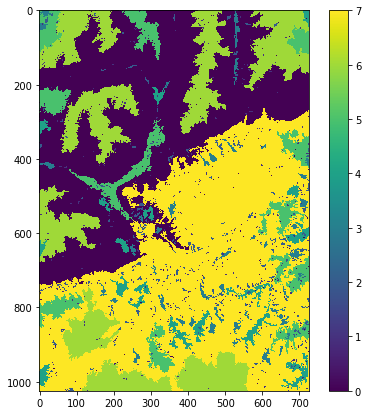

In [34]:
plt.figure(figsize=(7, 7))
plt.imshow(binned_metrics[1])
plt.colorbar()
plt.show()

In [37]:
def generate_all_layers(binned_metrics, mask, combo_df, nsp):
    """Create single combined ID array and calculate the optimum number of sample sites in each ID """
    imheight, imwidth = mask.shape
    combo_num = len(combo_df)
    # create 3d array to store ID combo layers in
    all_layers = np.zeros((combo_num, imheight, imwidth))
    counts = []
    # Iterate through all unique ID combinations
    for i in range(combo_num):
        im_layer = np.ones((imheight, imwidth))
        for j in range(len(binned_metrics)):
            # Convert selected ID to binary for each metric, and multiply together to see where
            # combinations are in the landscape image
            im_layer = np.where(binned_metrics[j] == combo_df.iloc[i][j], 1, 0) * im_layer
        # Make sure invalid areas are set as zero
        layer_mask = im_layer * mask
        counts.append(np.sum(layer_mask))  # Store the number of pixels in each unique combo layer
        all_layers[i, :, :] = layer_mask  # Save combo Id layer in 3d array
    combo_df['Counts'] = counts
    ID_df = combo_df[combo_df.Counts != 0]  # remove empty bins to create ID dataframe
    s_opt = np.float(nsp) / len(ID_df)  # optimum sample sites in each ID
    ID_df = ID_df[ID_df.Counts >= 10 * np.ceil(s_opt)]  # remove IDs with too few pixels
    s_opt = np.float(nsp) / len(ID_df)
    return all_layers, ID_df, s_opt


all_layers, ID_df, s_opt = generate_all_layers(binned_metrics, mask, combo_df, nsp)


In [49]:
save_path = 'test'

def generate_ID_im(all_layers, ID_df, nsp, savepath):
    imdepth, imheight, imwidth = all_layers.shape
    ID_im = np.zeros((imheight, imwidth))
    store_masks = np.zeros((len(ID_df), imheight, imwidth))
    counter = 0;
    unique_IDs = []
    for k in ID_df.index.values:
        store_masks[counter, :, :] = all_layers[k, :, :]
        ID_im += all_layers[k, :, :] * (counter + 1)
        unique_IDs.append(counter + 1)
        counter += 1
    # Save an ID image for adapted uniform designs
    # np.save("{0}/{1}Site_Uniform_IDim".format(savepath, nsp), ID_im)
    return store_masks, ID_im, unique_IDs

store_masks, ID_im, unique_IDs = generate_ID_im(all_layers, ID_df, nsp, save_path)
print(unique_IDs)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62]


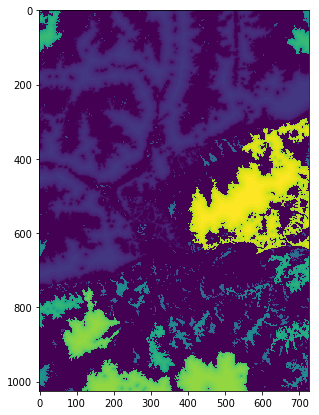

In [48]:
plt.figure(figsize=(7, 7))
plt.imshow(ID_im)
plt.show()

In [54]:
def generate_id_list(unique_IDs, s_opt, nsp, ID_df):
    """Create a list where each unique ID is repeated by s_opt"""
    id_rep = np.repeat(unique_IDs, np.floor(s_opt))
    # If there is a difference in the number of sample sites and the number of elements
    # in id_rep then add extras randomly from the list of IDs, without replacement
    diff = nsp - len(id_rep)
    while diff >= len(unique_IDs):
        id_rep = np.hstack([id_rep, unique_IDs])
        diff = nsp - len(id_rep)
    extra_sites = np.random.choice(unique_IDs, nsp - len(id_rep), replace=False)
    id_list = np.hstack([id_rep, extra_sites])  # Now list of length nsp
    # Randomly permute list
    id_mix = np.random.choice(id_list, nsp, replace=False)
    # If nsp is less than the number of IDs (i.e one or less sample per ID),
    # then create a reduced dataframe
    if len(id_mix) < len(unique_IDs):
        id_mix.sort()
        ID_df = ID_df.iloc[id_mix]
    ID_df['Freq'] = np.unique(id_mix, return_counts=True)[1]
    return id_mix, ID_df

s_opt = 2
id_mix, ID_df = generate_id_list(unique_IDs, s_opt, nsp, ID_df)


IndexError: positional indexers are out-of-bounds

In [52]:
s_opt

0.4838709677419355